# Introduction

This is a dataset for binary sentiment classification. It provides a set of 50,000 polar movie reviews for training and testing.

Firstly, downlaod and import everything that will be used

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import KeyedVectors
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random

# nltk.download('stopwords')
# nltk.download("punkt")
# nltk.download('punkt_tab')
# nltk.download('wordnet')

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Now, load data from cloud

In [33]:
train_data_path = "https://drive.google.com/uc?export=download&id=16CHSMU1ffqMZc__bTZngjZOjREghWKid"
test_data_path = "https://drive.google.com/uc?export=download&id=1tUMuS0ol19IUO8zgOcHpHWLV2pQVA8qZ"

# Get data locally during developing to avoid fetching time. (!) Comment when deploying and uncomment upper two
# train_data_path = "../work_data/train.csv"
# test_data_path = "../work_data/test.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# EDA

Check for NAs:

In [34]:
train_data.isnull().sum()

review       0
sentiment    0
dtype: int64

Luckily, none

Now, let's check our dataset for imbalance so we know are any additional steps required:

<Axes: xlabel='count', ylabel='sentiment'>

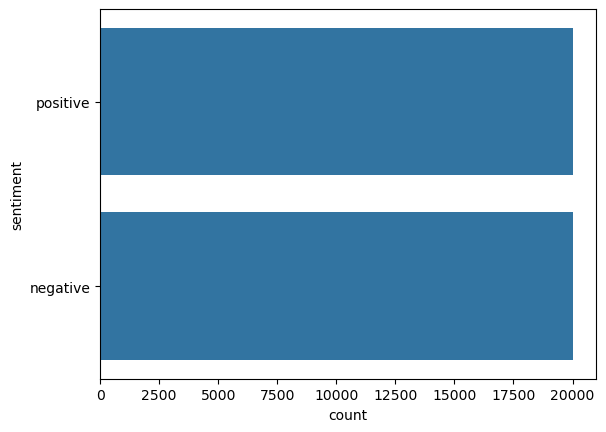

In [35]:
sns.countplot(train_data["sentiment"])

Again, luckily for is, the dataset is ideally balanced.

# Feature engineering

In [36]:
X_train = train_data["review"]
y_train = train_data["sentiment"]

X_test = test_data["review"]
y_test = test_data["sentiment"]

## Data cleaning

As a first step, i will remove any redundant characters, that doesnt provide any value for sentiment analysis:

In [37]:
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with single space
    text = re.sub(r'^b\s+', '', text)  # Remove prefixed 'b'
    text = text.lower()
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

X_train.head(2)


0    i caught this little gem totally by accident b...
1    i can believe that let myself into this movie ...
Name: review, dtype: object

## Tokenization

Now, I will perform tokenization. In this case, I decided that making each word separate token is good enough for the task:

In [38]:
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

X_train = X_train.apply(tokenize)
X_test = X_test.apply(tokenize)

X_train.to_frame().head()

,review
0,"[i, caught, this, little, gem, totally, by, ac..."
1,"[i, can, believe, that, let, myself, into, thi..."
2,"[spoiler, alert, it, just, gets, to, me, the, ..."
3,"[if, there, one, thing, ve, learnt, from, watc..."
4,"[i, remember, when, this, was, in, theaters, r..."


## Stop-words filtering

Now, removing stopwords. Applies the same logic as in removing characters: removing that ones, which will not provide any value for sentiment analysis, but now we will use predefined downloaded set of stopwords.

In [39]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return [word for word in text if word not in STOPWORDS]

X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

X_train.head()

0    [caught, little, gem, totally, accident, back,...
1    [believe, let, movie, accomplish, favor, frien...
2    [spoiler, alert, gets, nerve, people, remake, ...
3    [one, thing, learnt, watching, george, romero,...
4    [remember, theaters, reviews, said, horrible, ...
Name: review, dtype: object

It's seen on example that it removed words like "I", "this", "by" and etc.

## Stemming vs Lemmatization

Stemming and lemmatization are both techniques used to reduce words to their base or root form.

Stemming is a rule-based process that removes suffixes to get the root form of a word, often leading to non-real words.

Lemmatization reduces words to their dictionary form (lemma) using linguistic knowledge, ensuring real words.

To decide which one to use, I need to try both:

### Stemming

In [40]:
stemmer = PorterStemmer()

def stem_words(text):
    return [stemmer.stem(word) for word in text]

X_train_stemmed = X_train.apply(stem_words)

X_train_stemmed.head()

0    [caught, littl, gem, total, accid, back, 1980,...
1    [believ, let, movi, accomplish, favor, friend,...
2    [spoiler, alert, get, nerv, peopl, remak, use,...
3    [one, thing, learnt, watch, georg, romero, cre...
4    [rememb, theater, review, said, horribl, well,...
Name: review, dtype: object

### Lemmatization



In [41]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return [lemmatizer.lemmatize(word) for word in text]

X_train_lemmatized = X_train.apply(lemmatize_words)

X_train_lemmatized.head()

0    [caught, little, gem, totally, accident, back,...
1    [believe, let, movie, accomplish, favor, frien...
2    [spoiler, alert, get, nerve, people, remake, u...
3    [one, thing, learnt, watching, george, romero,...
4    [remember, theater, review, said, horrible, we...
Name: review, dtype: object

Now, conclusions. While lemmatization has left some wordds unchanged (like caught, learnt), it provided much more accurate results, while stemming often made not existing words (which is really important considering I will later try word embedding), and at the same time, lemmatization was ~3 times faster for me. That leaves no room for any reason to not prefer lemmatization over stemming

In [42]:
X_train = X_train_lemmatized

X_test = X_test.apply(lemmatize_words)

## Vectorization

Machine learning models cant work with strings: they firstly need to be converted to some numerical form. I will try to different methods of vectorization: Bag-of-Words and Word Embedding

### Bag-of-Words

-A simple, frequency-based text representation where each word is treated as an independent feature

In [43]:
vectorizer = CountVectorizer()

X_train = X_train.apply(lambda words: ' '.join(words))  # Convert lists to strings
X_train_bow = vectorizer.fit_transform(X_train)


In [44]:
X_test = X_test.apply(lambda words: ' '.join(words))

### Word Embedding

Word embedding is on the other hand, a dense vector representation of words that captures semantic meaning and relationships, that positively distinguishes this method from the previous one. While its pros are obvious, the cons are that it requires more computation, and needs either big dataset to train effectively or pretrained models. In this case, i will use one called Word2Vec:

In [45]:
word2vec = api.load("word2vec-google-news-300")
# word2vec = KeyedVectors.load("word2vec-google-news-300.kv", mmap='r')

# Little test to ensure its working
vector = word2vec["king"]
similarity = word2vec.similarity("king", "queen")

In [46]:
similarity

0.6510957

In [47]:
# word2vec.save("word2vec-google-news-300.kv")

Conclusions: for sentiment analysis, Word embediing is much, much more suitable choice, so I will go on with it

# Modeling

Now that we applied vectorization to datasets, usual clssification models can be used to do sentiment nalysys.

In [48]:
X_train = X_train.apply(tokenize)
X_test = X_test.apply(tokenize)

In [49]:
X_train

0        [caught, little, gem, totally, accident, back,...
1        [believe, let, movie, accomplish, favor, frien...
2        [spoiler, alert, get, nerve, people, remake, u...
3        [one, thing, learnt, watching, george, romero,...
4        [remember, theater, review, said, horrible, we...
                               ...                        
39995    [1920s, man, named, walt, disney, mission, sat...
39996    [first, time, saw, shade, sneakpreview, even, ...
39997    [waste, time, danger, watch, tempted, tear, dv...
39998    [far, pathetic, movie, indian, cinema, cinema,...
39999    [movie, forever, left, impression, watched, fr...
Name: review, Length: 40000, dtype: object

In [50]:
def get_average_word2vec(tokens_list, model, num_features=300):
    # Filter tokens that exist in the Word2Vec vocabulary
    tokens = [word for word in tokens_list if word in model.key_to_index]
    
    if len(tokens) == 0:  # If no valid words in the model, return a zero vector
        return np.zeros(num_features)
    
    # Calculate the average of word vectors for the tokens
    word_vectors = [model[word] for word in tokens]
    avg_vector = np.mean(word_vectors, axis=0)
    
    return avg_vector

# Apply to your tokenized reviews
X_train = np.array([get_average_word2vec(review, word2vec) for review in X_train])


X_test = np.array([get_average_word2vec(review, word2vec) for review in X_test])

# Now, X_train_word2vec is a 2D array with each row representing the average Word2Vec vector for each review.


In [51]:
X_train

array([[ 0.06581443,  0.01023283,  0.0313708 , ..., -0.06038393,
         0.01935032,  0.00904265],
       [ 0.07401692,  0.02514042,  0.00329694, ..., -0.05986691,
         0.04118495, -0.00026885],
       [ 0.05933053, -0.01295399,  0.03067889, ..., -0.06609236,
        -0.00385938, -0.01924606],
       ...,
       [ 0.06910837,  0.06125518,  0.01687556, ..., -0.09493661,
        -0.02089013,  0.00164983],
       [ 0.07151088,  0.01659382,  0.01234732, ..., -0.0511319 ,
         0.00589957,  0.00461692],
       [ 0.06243185,  0.02599386,  0.01262385, ..., -0.04069519,
         0.03703458,  0.00198275]], dtype=float32)

In [52]:
y_train = y_train.apply(lambda x: 1 if x == 'positive' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'positive' else 0)


## Logistic regression

In [53]:
from sklearn.linear_model import LogisticRegression

# Check the shape before fitting
print("X_train shape:", X_train.shape)  # Should be (num_reviews, 300)
print("y_train shape:", y_train.shape)          # Should be (num_reviews,)

# Train logistic regression model
model = LogisticRegression(max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)  # No need to convert y_train to array

# Predictions
y_pred = model.predict(X_test)

y_pred

X_train shape: (40000, 300)
y_train shape: (40000,)


array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [54]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8554


## Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


Random Forest Accuracy: 0.8100


## SVM

In [56]:
from sklearn.svm import SVC

svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


SVM Accuracy: 0.8629


## DL

In [57]:
# Define the model
model_keras = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_keras.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the model
history = model_keras.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test))

# Predictions
y_pred_keras = model_keras.predict(X_test)
y_pred_keras_classes = (y_pred_keras > 0.5).astype(int)

# Evaluate the model
accuracy = (y_pred_keras_classes.flatten() == y_test).mean()
print(f"Keras Model Accuracy: {accuracy:.4f}")


c:\Users\ghj\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6458 - loss: 0.6070 - val_accuracy: 0.8398 - val_loss: 0.3667
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8353 - loss: 0.3969 - val_accuracy: 0.8465 - val_loss: 0.3489
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8433 - loss: 0.3735 - val_accuracy: 0.8456 - val_loss: 0.3470
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8492 - loss: 0.3630 - val_accuracy: 0.8501 - val_loss: 0.3430
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8491 - loss: 0.3592 - val_accuracy: 0.8572 - val_loss: 0.3324
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8526 - loss: 0.3536 - val_accuracy: 0.8509 - val_loss: 0.3341
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8522 - loss: 0.3469 - val_accuracy: 0.8557 - val_loss: 0.3310
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8541 - loss: 0.3485 - val_accuracy: 0.

For my final project (MLE part) I will choose Logistic Regressions. It's simple, has a accuracy score not much less than DL model or SVM (0.8554 against ~0.86), and extremely fast.

Of course, my results aren't 100% accurate. I could have played more with hyperparameters tuning, try more DL model architectures (I actually did it but left it all behind in final notebook version). I could have tried more vectorization methods, like TF-IDF. But at the end, chosen model completes our task — sentiment analysis with accuracy > 0.85, so I will b satisfied for now with this result.